# Testování rekurentních neuronových sítí

In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

## Recurrent Neural Network

In [2]:
class Predictor(nn.Module):
    def __init__(self, input_size, hidden_size,
                 output_size, num_layers=1):
        super(Predictor, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        batch_size = x.shape[0]
        
        rnn_out, hidden = self.rnn(x, hidden)
        out = self.fc(rnn_out)
        
        return out, hidden

predictor = Predictor(input_size=1,
                      hidden_size=16,
                      output_size=1)
predictor

Predictor(
  (rnn): LSTM(1, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

## Sinus

(dtype('float32'), dtype('float32'))

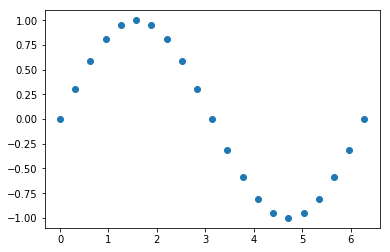

In [3]:
seq_len = 20
time_steps = np.linspace(0, 2 * np.pi, seq_len + 1,
                         dtype=np.float32)
data = np.sin(time_steps)

plt.plot(time_steps, data, 'o')

time_steps.dtype, data.dtype

((1, 20, 1), (20,))

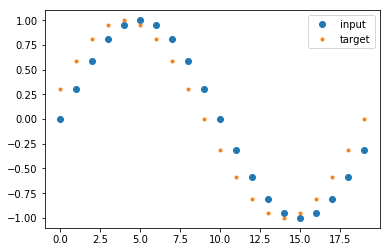

In [4]:
X = data[:-1].reshape(1, -1, 1)
y = data[1:]

plt.plot(X.ravel(), 'o', label='input')
plt.plot(y, '.', label='target')
plt.legend()

X.shape, y.shape

In [5]:
X_tensor = torch.from_numpy(X)
y_tensor = torch.from_numpy(y)
X_tensor.size(), y_tensor.size()

(torch.Size([1, 20, 1]), torch.Size([20]))

In [6]:
X_tensor.dtype, y_tensor.dtype

(torch.float32, torch.float32)

In [7]:
out, hidden = predictor(X_tensor, hidden=None)
out.size()

torch.Size([1, 20, 1])

### Loss and Optimization

In [8]:
def train(predictor, criterion, optimizer,
          n_epochs, seq_len=20):
    print_every = n_epochs // 10
    hidden = None
    for epoch in range(n_epochs):
        time_steps = np.linspace(epoch * np.pi,
                                (epoch + 2) * np.pi,
                                seq_len + 1,
                                dtype=np.float32)
        data = np.sin(time_steps)
        X = data[:-1].reshape(1, -1, 1)
        y = data[1:]
        
        X_tensor = torch.from_numpy(X)
        y_tensor = torch.from_numpy(y)
        
        pred, hidden = predictor(X_tensor, hidden)
        
        hidden = tuple([h.data for h in hidden])
        
        loss = criterion(pred.view(-1), y_tensor)
        optimizer.zero_grad()
        loss.backward()
        # TODO maybe clip gradients
        # `nn.utils.clip_grad_norm_(predictor.parameters(), clip )`
        optimizer.step()
        
        if epoch % print_every == 0:
            print('epoch: {:3d} loss: {:6.4f}'.format(epoch,
                                                      loss.item()))

predictor = Predictor(input_size=1,
                      hidden_size=16,
                      output_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(predictor.parameters())
train(predictor, criterion, optimizer, n_epochs=1000)

epoch:   0 loss: 0.5195
epoch: 100 loss: 0.2263
epoch: 200 loss: 0.0827
epoch: 300 loss: 0.0555
epoch: 400 loss: 0.0464
epoch: 500 loss: 0.0436
epoch: 600 loss: 0.0284
epoch: 700 loss: 0.0252
epoch: 800 loss: 0.0236
epoch: 900 loss: 0.0225


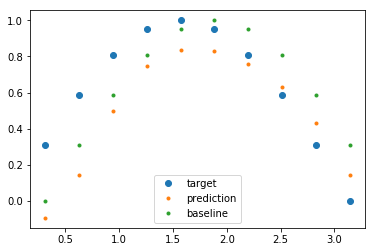

predictor RMSE: 0.2409
baseline RMSE:  0.2212


In [9]:
time_steps = np.linspace(0, np.pi, seq_len // 2 + 1,
                         dtype=np.float32)
data = np.sin(time_steps)
X = data[:-1].reshape(1, -1, 1)
y = data[1:]

X_tensor = torch.from_numpy(X)

with torch.no_grad():
    y_pred, _ = predictor(X_tensor, None)
    y_pred = y_pred.data.numpy().ravel()

plt.plot(time_steps[1:], y, 'o', label='target')
plt.plot(time_steps[1:], y_pred,
         '.', label='prediction')
plt.plot(time_steps[1:], X.ravel(),
         '.', label='baseline')
plt.legend()
plt.show()

test_rmse = np.sqrt(metrics.mean_squared_error(y, y_pred))
# baseline
baseline_rmse = np.sqrt(metrics.mean_squared_error(y, X.ravel()))

print('predictor RMSE: {:6.4f}'.format(test_rmse))
print('baseline RMSE:  {:6.4f}'.format(baseline_rmse))

## Beijing PM2.5 Data Data Set

Zdroj: http://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data.

In [10]:
def parse_date(year, month, day, hour):
    date = '{} {} {} {}'.format(year, month, day, hour)
    return datetime.strptime(date, '%Y %m %d %H')

data = pd.read_csv('data/pollution.csv',
                   parse_dates=[['year', 'month', 'day', 'hour']],
                   index_col=0, date_parser=parse_date)
data.drop('No', axis=1, inplace=True)
data.columns = ['pollution', 'dew', 'temp', 'press', 'wnd dir', 'wnd spd', 'snow', 'rain']
data.index.name = 'date'
# mark all NA values with 0
data['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
data = data[24:]
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43800 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
pollution    43800 non-null float64
dew          43800 non-null int64
temp         43800 non-null float64
press        43800 non-null float64
wnd dir      43800 non-null object
wnd spd      43800 non-null float64
snow         43800 non-null int64
rain         43800 non-null int64
dtypes: float64(4), int64(3), object(1)
memory usage: 3.0+ MB


,pollution,dew,temp,press,wnd dir,wnd spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


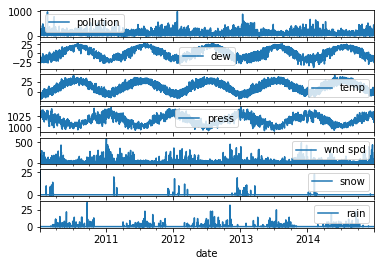

In [11]:
columns = ['pollution', 'dew', 'temp', 'press', 'wnd spd', 'snow', 'rain']
fig, axs = plt.subplots(nrows=len(columns), sharex=True)
for ax, column in zip(axs, columns):
    data[column].plot(ax=ax, label=column)
    ax.legend()

In [12]:
encoder = preprocessing.LabelEncoder()
data['wnd dir'] = encoder.fit_transform(data['wnd dir'])
data['target'] = data['pollution'].shift(-1)
data.dropna(inplace=True)
data = data.astype('float32')
data.head()

,pollution,dew,temp,press,wnd dir,wnd spd,snow,rain,target
date,,,,,,,,,
2010-01-02 00:00:00,129.0,-16.0,-4.0,1020.0,2.0,1.79,0.0,0.0,148.0
2010-01-02 01:00:00,148.0,-15.0,-4.0,1020.0,2.0,2.68,0.0,0.0,159.0
2010-01-02 02:00:00,159.0,-11.0,-5.0,1021.0,2.0,3.57,0.0,0.0,181.0
2010-01-02 03:00:00,181.0,-7.0,-5.0,1022.0,2.0,5.36,1.0,0.0,138.0
2010-01-02 04:00:00,138.0,-7.0,-5.0,1022.0,2.0,6.25,2.0,0.0,109.0


In [13]:
X = data.values[:, :-1]
y = data.values[:, -1:]

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.2, shuffle=False)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((35039, 8), (35039, 1), (8760, 8), (8760, 1))

In [14]:
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = preprocessing.MinMaxScaler(feature_range=(-1, 1))
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

(X_train_scaled.shape, y_train_scaled.shape,
 X_test_scaled.shape, y_test_scaled.shape)

((35039, 8), (35039, 1), (8760, 8), (8760, 1))

In [15]:
X_train_tensor = torch.from_numpy(X_train_scaled)
y_train_tensor = torch.from_numpy(y_train_scaled)
X_test_tensor = torch.from_numpy(X_test_scaled)
y_test_tensor = torch.from_numpy(y_test_scaled)

(X_train_tensor.size(), y_train_tensor.size(),
 X_test_tensor.size(), y_test_tensor.size())

(torch.Size([35039, 8]),
 torch.Size([35039, 1]),
 torch.Size([8760, 8]),
 torch.Size([8760, 1]))

In [16]:
n_epochs = 50
batch_size = 72

predictor = Predictor(input_size=8, hidden_size=64, output_size=1,
                      num_layers=2)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(predictor.parameters())

train_dataset = TensorDataset(X_train_tensor,
                              y_train_tensor)
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=False)

train_losses = []
test_losses = []

for epoch in range(1, n_epochs + 1):
    hidden = None
    train_loss = 0
    for inputs, labels in train_loader:
        inputs = inputs.unsqueeze(0)
        pred, hidden = predictor(inputs, hidden)
        loss = criterion(pred.squeeze(dim=0), labels)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        # TODO maybe clip gradients
        # `nn.utils.clip_grad_norm_(predictor.parameters(), clip )`
        optimizer.step()
        
        hidden = tuple([h.data for h in hidden])
    
    with torch.no_grad():
        pred, _ = predictor(X_test_tensor.unsqueeze(0), hidden=None)
        test_loss = criterion(pred.squeeze(dim=0), y_test_tensor).item()
    
    train_losses.append(train_loss / X_train.shape[0])
    test_losses.append(test_loss / X_test.shape[0])
    
    print('epoch: {:4d} train loss: {:8.6f} test loss: {:8.6f}'.format(
            epoch, train_losses[-1], test_losses[-1]))

epoch:    1 train loss: 0.029505 test loss: 0.075256
epoch:    2 train loss: 0.007909 test loss: 0.021882
epoch:    3 train loss: 0.004459 test loss: 0.008973
epoch:    4 train loss: 0.003451 test loss: 0.006179
epoch:    5 train loss: 0.003273 test loss: 0.005563
epoch:    6 train loss: 0.003216 test loss: 0.005388
epoch:    7 train loss: 0.003178 test loss: 0.005350
epoch:    8 train loss: 0.003153 test loss: 0.005363
epoch:    9 train loss: 0.003139 test loss: 0.005406
epoch:   10 train loss: 0.003127 test loss: 0.005487
epoch:   11 train loss: 0.003114 test loss: 0.005569
epoch:   12 train loss: 0.003102 test loss: 0.005599
epoch:   13 train loss: 0.003097 test loss: 0.005605
epoch:   14 train loss: 0.003105 test loss: 0.005522
epoch:   15 train loss: 0.003097 test loss: 0.005400
epoch:   16 train loss: 0.003055 test loss: 0.005028
epoch:   17 train loss: 0.003034 test loss: 0.005437
epoch:   18 train loss: 0.002999 test loss: 0.004582
epoch:   19 train loss: 0.003013 test loss: 0.

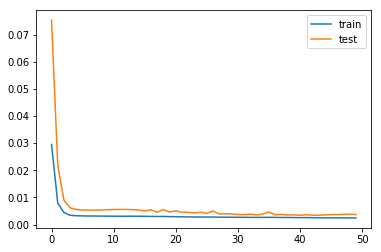

In [17]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()
plt.show()

In [18]:
with torch.no_grad():
    y_pred_tensor, _ = predictor(X_test_tensor.unsqueeze(0), hidden=None)

y_pred_scaled = y_pred_tensor.squeeze(dim=0).numpy()
y_pred = scaler_y.inverse_transform(y_pred_scaled)

throw_away = 2

test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
y_base = X_test[:, :1]
baseline_rmse = np.sqrt(metrics.mean_squared_error(y_base, y_test))

print('LSTM test RMSE:     {:8.6f}'.format(test_rmse))
print('baseline test RMSE: {:8.6f}'.format(baseline_rmse))

LSTM test RMSE:     30.178831
baseline test RMSE: 24.514713


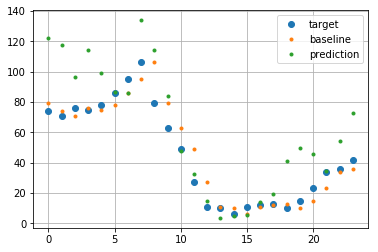

In [19]:
start = 24 * 256
size = 24
plt.plot(y_test[start:(start + size)], 'o', label='target')
plt.plot(y_base[start:(start + size)], '.', label='baseline')
plt.plot(y_pred[start:(start + size)], '.', label='prediction')
plt.grid()
plt.legend();